## Group 06 - Final Project

This project would demonstrate an interface to search TV shows/movies in the Netflix, Amazon Prime, Hulu, and DisneyPlus Databases. The user would be able to choose among the four platforms as they wanted. In addition to the basic information and description of the TV shows/movies, this interface also provides TomatoMeter, a rating scale that is published by the website Rotten Tomatoes. When the chosen TV shows/movies don't have a TomatoMeter on the Rotten Tomatoes website, the program would provide a link to the Rotten Tomatoes website for additional information. You can start by typing the keyword "love." Enjoy!

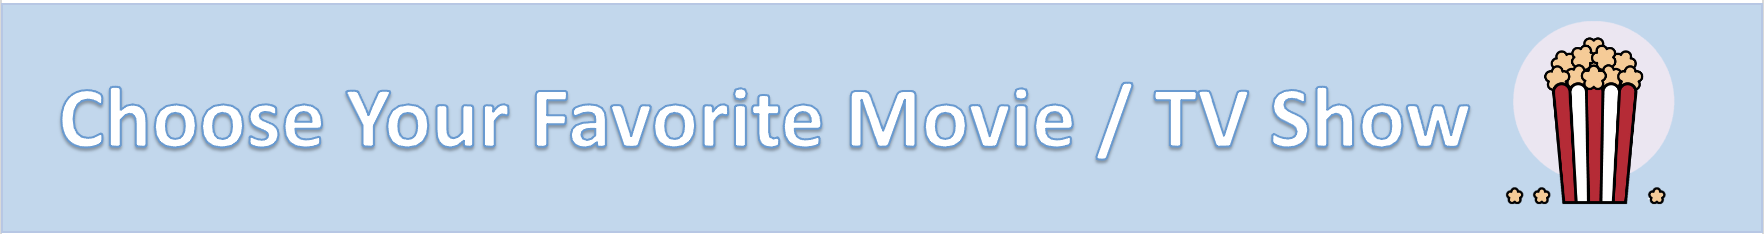

Output()

Output()

Output()

In [4]:
#imports
import ipywidgets as widget
import pandas as pd
import sqlite3
import sys
from urllib.parse import urlencode
import urllib.request
import json
import re
from IPython.display import display, clear_output
from ipywidgets import Layout
from IPython.display import Image


#connect the web and get tomatometer. Return tomatometer
def tomatorate(typee,name):
    
    # to change and return the name of the show into the format of web-readable.
    def showname(name):
        name = name.lower()
        new_name = ''
        for i in name:
            if i == ' ' or i == ',' or i == '&' or i == ':' or i == '/':
                new_name = new_name+'_'
            else:
                new_name = new_name+i
        while True:
            check = new_name.find('__')
            if check == -1:
                return new_name
                break
            else:
                new_name = new_name[0:check]+new_name[check+1:len(new_name)]
    
    # Using re to get the tomatoter, which is in specific pattern. Return the string of the tomatometer.
    def changetomato(rate):
        pattern = re.compile('(\d+%).*')
        m = pattern.search(rate)
        if m:
            return(m.group(1))
        
    changed_tomatometer = ''
    
    
    try:
        web = 'https://www.rottentomatoes.com'
        #tv/m
        typ = typee
        name = showname(name)
        
        #the pattern fails to get the tomatometer from the movie, since the web of movie is highly complicated
        if typ == 'm':
            changed_tomatometer = (f"Sorry, we didn't find it. Instead you can check {web}/{typ}/{name}")
            return changed_tomatometer
        # return the tomatometer
        else:
            
            tomatometer = ''
            #open web
            response_object = urllib.request.urlopen(web+'/'+typ+'/'+name)

            #get
            response_as_string = response_object.read()
            #convert to str
            response = str(response_as_string)
            #the tomatometer
            to = 'data-qa="tomatometer">'
    
            #once find, get index and then the tomatometer
            index = response.find(to)
            start = index+64
            end = index+68
            if index != -1:
                tomatometer = response[start:end]
                changed_tomatometer = changetomato(tomatometer)
            else:
                changed_tomatometer = (f"Sorry, we didn't find it. Instead you can check {web}/{typ}/{name}")
            return changed_tomatometer
    
    except:
        changed_tomatometer = (f"Sorry, we didn't find it.")
        return changed_tomatometer
    
# connect the result from the database to api
def findtomato(result):
    tomato = ''
    
    #transform the information from database to suit the api function above, and return the tomatometer
    if result[0][1] == 'Movie':
        tomato = tomatorate('m',result[0][0])
    elif result[0][1] == 'TV Show':
        tomato = tomatorate('tv',result[0][0])
    
    return tomato

def displayall():
    #style of the widget
    style = {'description_width': 'initial','value_wideth':'initial'}
    
    # Connecting database
    try:
        connection = sqlite3.connect('video_data.db')
    except Exception as ex:
        print(f'Exception connecting to database: {ex}')
        sys.exit()

    # Define and set up widgets
    search_box =  widget.Text(
        value='Hello World',
        placeholder='Type something',
        description='Type the movie/show you want to search',
        style=style,
        layout=Layout(width='50%', height='80px'),
        disabled=False
    )
    
    search_button = widget.Button(description = 'Search',icon='fa-paper-plane' )

    select = widget.Select(options= '' , description="Choose the movie:",style=style,layout=Layout( height='300px'))

    information =  widget.Textarea(
        value='',
        placeholder='',
        description='',
        style=style,
        layout=Layout(width='50%', height='300px'),
        disabled=False
    )

    tomatowidget = widget.Text(value = '')

    more_like_this_button = widget.Button(description = 'More Like This', button_style='warning',icon='fa-heart')

    recommend = widget.Select(options = '', description = '' )
    
    choose_platform = widget.Dropdown(
        options=['Netflix', 'Amazon Prime', 'Hulu', 'Disney Plus'],
        value='Netflix',
        description='Choose a platform: ',
        style=style,
        disabled=False,
    )
    
    #Output Widget
    
    out = widget.Output()

    out2 = widget.Output()

    out3 = widget.Output()
    
    out4 = widget.Output()
    
    with out:
        row1 = widget.HBox([
            choose_platform
        ])
        
        row2 = widget.HBox([
            search_box,
            search_button
        ])
        keypad = widget.VBox([row1,row2])
        display(keypad)
            
    #the function that returns a list titles of movies and tv shows based on the genre of input value
        
    def find(platform, search):  
        result = ()
        if platform == 'Netflix':
            result =  connection.execute('SELECT title FROM  netflix_titles WHERE title LIKE ?',(s_value_change(search),))
        elif platform=='Hulu':
            result =  connection.execute('SELECT title FROM hulu_titles WHERE title LIKE ?',(s_value_change(search),))
        elif platform=='Amazon Prime':
            result =  connection.execute('SELECT title FROM amazon_prime_titles WHERE title LIKE ?',(s_value_change(search),))
        elif platform=='Disney Plus':
            result =  connection.execute('SELECT title FROM disney_plus_titles WHERE title LIKE ?',(s_value_change(search),))
            
        selections = []
        for i in result:
            selections.append(i[0])
        return selections
    
     
        
    
    #the function that returns a list of recommended movies and tv shows based on input genre
    def findrec(platform, search):
    #return the genre of the show based on result
        def find_genre(i):
            pattern = re.compile('.+\nGenre: (.+)\n.+')
            m = pattern.search(i)
            if m:
                return(m.group(1))
        
        genre = find_genre(search)
        if platform == 'Netflix' :
            reco = connection.execute('SELECT title FROM netflix_titles Where listed_in LIKE ? LIMIT 5', (s_value_change(genre),))
        elif platform == 'Hulu' :
            reco = connection.execute('SELECT title FROM hulu_titles Where listed_in LIKE ? LIMIT 5', (s_value_change(genre),))
        elif platform == 'Disney Plus' :
            reco = connection.execute('SELECT title FROM disney_plus_titles Where listed_in LIKE ? LIMIT 5', (s_value_change(genre),))
        elif platform == 'Amazon Prime':
            reco = connection.execute('SELECT title FROM amazon_prime_titles Where listed_in LIKE ? LIMIT 5', (s_value_change(genre),))
            
            
        selections = []
        for i in reco:
            selections.append(i[0])
        return selections
        
    

    # return a new search which would be used for LIKE in sql
    def s_value_change(search):
        new_search = '%'+search+'%'
        return new_search

    
    def click_handler(arg):
    
        select.options = find(choose_platform.value,search_box.value)
        with out2:
            clear_output()
            row1 = widget.HBox([
            select,
            information])
            keypad = widget.VBox([row1])
            display(keypad)
            display(more_like_this_button)

#after selecting or changing titles, display information
    def change_handler(change):
        r = ()
        if choose_platform.value == 'Netflix':
            r = connection.execute('SELECT title,type,director,cast1,country,release_year,duration,listed_in,description FROM netflix_titles WHERE title = ?',(change['new'],))
        elif choose_platform.value == 'Hulu':
            r = connection.execute('SELECT title,type,director,cast1,country,release_year,duration,listed_in,description FROM Hulu_titles WHERE title = ?',(change['new'],))
        elif choose_platform.value == 'Amazon Prime':
            r = connection.execute('SELECT title,type,director,cast1,country,release_year,duration,listed_in,description FROM amazon_prime_titles WHERE title = ?',(change['new'],))
        elif choose_platform.value == 'Disney Plus':
            r = connection.execute('SELECT title,type,director,cast1,country,release_year,duration,listed_in,description FROM disney_plus_titles WHERE title = ?',(change['new'],))
            
        
        result = list(r)
        
        tomato = findtomato(result)
        
        with out2:
            information.value = f'Name: {result[0][0]}\nType: {result[0][1]}\nDirector: {result[0][2]}\nCast: {result[0][3]}\nCountry: {result[0][4]}\nYear: {result[0][5]}\nDuration: {result[0][6]}\nGenre: {result[0][7]}\nDescription: {result[0][8]}\nTomatoMeter From Rotten Tomatoes Website: {tomato}'
        
 # after clicking recommend, the third output would be displayed   
    def click_handler2(arg):
        recommend.options = findrec(choose_platform.value, information.value)
        with out3:
            clear_output()
            display(recommend)
        
    search_button.on_click(click_handler)
    select.observe(change_handler, names = 'value')
    more_like_this_button.on_click(click_handler2)
    
    display(Image("headline_1.png"))
    display(out)
    display(out2)
    display(out3)
    
def main():
    displayall()

main()